In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import astropy.units as u
from astropy.table import QTable

import warnings
from matplotlib.ticker import MultipleLocator
import pickle
from scipy.interpolate import interp1d

In [2]:
full_ideal_res = QTable.read("Data/FIT_AND_CLOUDY_RESULTS.fits")


In [3]:
# No metallicity dependence for CIE for T> 1e4 K
CIE_T, CIE_HII, CIE_CIV, CIE_OVI, CIE_SiIV = np.loadtxt("Data/Gnat2007_Models/CIE_Z1.txt", 
                                                        skiprows = 126, 
                                                        usecols = [0,2,9,26,57],
                                                        unpack = True)



In [4]:
ISOB_Zp1_T, ISOB_Zp1_HII, ISOB_Zp1_CIV, ISOB_Zp1_OVI, ISOB_Zp1_SiIV = np.loadtxt(
                                                        "Data/Gnat2007_Models/ISOB_Z-1.txt", 
                                                        skiprows = 124, 
                                                        usecols = [0,2,9,26,57],
                                                        unpack = True)

ISOCh_Zp1_T, ISOCh_Zp1_HII, ISOCh_Zp1_CIV, ISOCh_Zp1_OVI, ISOCh_Zp1_SiIV = np.loadtxt(
                                                        "Data/Gnat2007_Models/ISOCh_Z-1.txt", 
                                                        skiprows = 124, 
                                                        usecols = [0,2,9,26,57],
                                                        unpack = True)

In [5]:
#Abundances
#solar

logO_abund_solar = 8.69
logC_abund_solar = 8.43
logSi_abund_solar = 7.51

logO_abund = logO_abund_solar - 12
logC_abund = logC_abund_solar - 12
logSi_abund = logSi_abund_solar - 12


In [6]:
# Get Ratios
# CIV/SiIV

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    N_H = 22 # placeholder log column
    N_Si_Z1 = N_H + logSi_abund
    N_C_Z1 = N_H + logC_abund
    N_O_Z1 = N_H + logO_abund

    #CIE
    N_HII_CIE = N_H + np.log10(CIE_HII)

    N_SiIV_CIE = N_Si_Z1 + np.log10(CIE_SiIV)
    N_CIV_CIE = N_C_Z1 + np.log10(CIE_CIV)
    N_OVI_CIE = N_O_Z1 + np.log10(CIE_OVI)

    CIV_to_SiIV_CIE = N_CIV_CIE - N_SiIV_CIE
    OVI_to_CIV_CIE = N_OVI_CIE - N_CIV_CIE
    OVI_to_SiIV_CIE = N_OVI_CIE - N_SiIV_CIE
    HII_to_OVI_CIE = N_HII_CIE - N_OVI_CIE
    HII_to_CIV_CIE = N_HII_CIE - N_CIV_CIE
    
    
    #ISOB .1 Solar
    N_HII_ISOB_Zp1 = N_H + np.log10(ISOB_Zp1_HII)

    N_SiIV_ISOB_Zp1 = N_Si_Z1 - 1 + np.log10(ISOB_Zp1_SiIV)
    N_CIV_ISOB_Zp1 = N_C_Z1 - 1 + np.log10(ISOB_Zp1_CIV)
    N_OVI_ISOB_Zp1 = N_O_Z1 - 1 + np.log10(ISOB_Zp1_OVI)

    CIV_to_SiIV_ISOB_Zp1 = N_CIV_ISOB_Zp1 - N_SiIV_ISOB_Zp1
    OVI_to_CIV_ISOB_Zp1 = N_OVI_ISOB_Zp1 - N_CIV_ISOB_Zp1
    OVI_to_SiIV_ISOB_Zp1 = N_OVI_ISOB_Zp1 - N_SiIV_ISOB_Zp1
    HII_to_OVI_ISOB_Zp1 = N_HII_ISOB_Zp1 - N_OVI_ISOB_Zp1
    HII_to_CIV_ISOB_Zp1 = N_HII_ISOB_Zp1 - N_CIV_ISOB_Zp1

    #ISOCh .1 Solar
    N_HII_ISOCh_Zp1 = N_H + np.log10(ISOCh_Zp1_HII)

    N_SiIV_ISOCh_Zp1 = N_Si_Z1 - 1 + np.log10(ISOCh_Zp1_SiIV)
    N_CIV_ISOCh_Zp1 = N_C_Z1 - 1 + np.log10(ISOCh_Zp1_CIV)
    N_OVI_ISOCh_Zp1 = N_O_Z1 - 1 + np.log10(ISOCh_Zp1_OVI)

    CIV_to_SiIV_ISOCh_Zp1 = N_CIV_ISOCh_Zp1 - N_SiIV_ISOCh_Zp1
    OVI_to_CIV_ISOCh_Zp1 = N_OVI_ISOCh_Zp1 - N_CIV_ISOCh_Zp1
    OVI_to_SiIV_ISOCh_Zp1 = N_OVI_ISOCh_Zp1 - N_SiIV_ISOCh_Zp1
    HII_to_OVI_ISOCh_Zp1 = N_HII_ISOCh_Zp1 - N_OVI_ISOCh_Zp1
    HII_to_CIV_ISOCh_Zp1 = N_HII_ISOCh_Zp1 - N_CIV_ISOCh_Zp1

In [7]:
# Observed ratios

#CIV/SiIV
lc = np.ma.masked_array(np.log10(full_ideal_res["MEAS_N_CIV"].value), 
                        full_ideal_res["MEAS_ERR_N_CIV"] < 0)
lce = np.ma.masked_array(1/np.log(10) * full_ideal_res["MEAS_ERR_N_CIV"].value/full_ideal_res["MEAS_N_CIV"].value, 
                         full_ideal_res["MEAS_ERR_N_CIV"] < 0)

ls = np.ma.masked_array(np.log10(full_ideal_res["MEAS_N_SiIV"].value), 
                        full_ideal_res["MEAS_ERR_N_SiIV"] < 0)
lse = np.ma.masked_array(1/np.log(10) * full_ideal_res["MEAS_ERR_N_SiIV"].value/full_ideal_res["MEAS_N_SiIV"].value, 
                         full_ideal_res["MEAS_ERR_N_SiIV"] < 0)

full_ideal_res["LOG_CIV/SiIV"] = lc - ls
full_ideal_res["ERR_LOG_CIV/SiIV"] = lce + lse


#OVI/CIV
lo = np.ma.masked_array(np.log10(full_ideal_res["MEAS_N_OVI"].value), 
                        (full_ideal_res["MEAS_ERR_N_OVI"] < 0) | (np.isnan(full_ideal_res["MEAS_ERR_N_OVI"])))
loe = np.ma.masked_array(1/np.log(10) * full_ideal_res["MEAS_ERR_N_OVI"].value/full_ideal_res["MEAS_N_OVI"].value, 
                         (full_ideal_res["MEAS_ERR_N_OVI"] < 0) | (np.isnan(full_ideal_res["MEAS_ERR_N_OVI"])))


full_ideal_res["LOG_OVI/CIV"] = lo - lc
full_ideal_res["ERR_LOG_OVI/CIV"] = loe + lce


#OVI/SiIV

full_ideal_res["LOG_OVI/SiIV"] = lo - ls
full_ideal_res["ERR_LOG_OVI/SiIV"] = loe + lse



# Z = -1 Temperatures from CIV/SiIV

In [8]:
# polynomial fits to Colissional Models

mask_CIE = np.invert(np.isinf(CIV_to_SiIV_CIE) | np.isnan(CIV_to_SiIV_CIE))
CIE_CIV_SiIV_Trange = np.min(np.log10(CIE_T)[mask_CIE]), np.max(np.log10(CIE_T)[mask_CIE])
CIE_CIV_SiIV_poly = np.polyfit(np.log10(CIE_T)[mask_CIE], CIV_to_SiIV_CIE[mask_CIE], 11)

mask_ISOB = np.invert(np.isinf(CIV_to_SiIV_ISOB_Zp1) | np.isnan(CIV_to_SiIV_ISOB_Zp1))
ISOB_Zp1_CIV_SiIV_Trange = np.min(np.log10(ISOB_Zp1_T)[mask_ISOB]), np.max(np.log10(ISOB_Zp1_T)[mask_ISOB])
ISOB_Zp1_CIV_SiIV_poly = np.polyfit(np.log10(ISOB_Zp1_T)[mask_ISOB], CIV_to_SiIV_ISOB_Zp1[mask_ISOB], 11)

mask_ISOCh = np.invert(np.isinf(CIV_to_SiIV_ISOCh_Zp1) | np.isnan(CIV_to_SiIV_ISOCh_Zp1))
ISOCh_Zp1_CIV_SiIV_Trange = np.min(np.log10(ISOCh_Zp1_T)[mask_ISOCh]), np.max(np.log10(ISOCh_Zp1_T)[mask_ISOCh])
ISOCh_Zp1_CIV_SiIV_poly = np.polyfit(np.log10(ISOCh_Zp1_T)[mask_ISOCh], CIV_to_SiIV_ISOCh_Zp1[mask_ISOCh], 11)

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


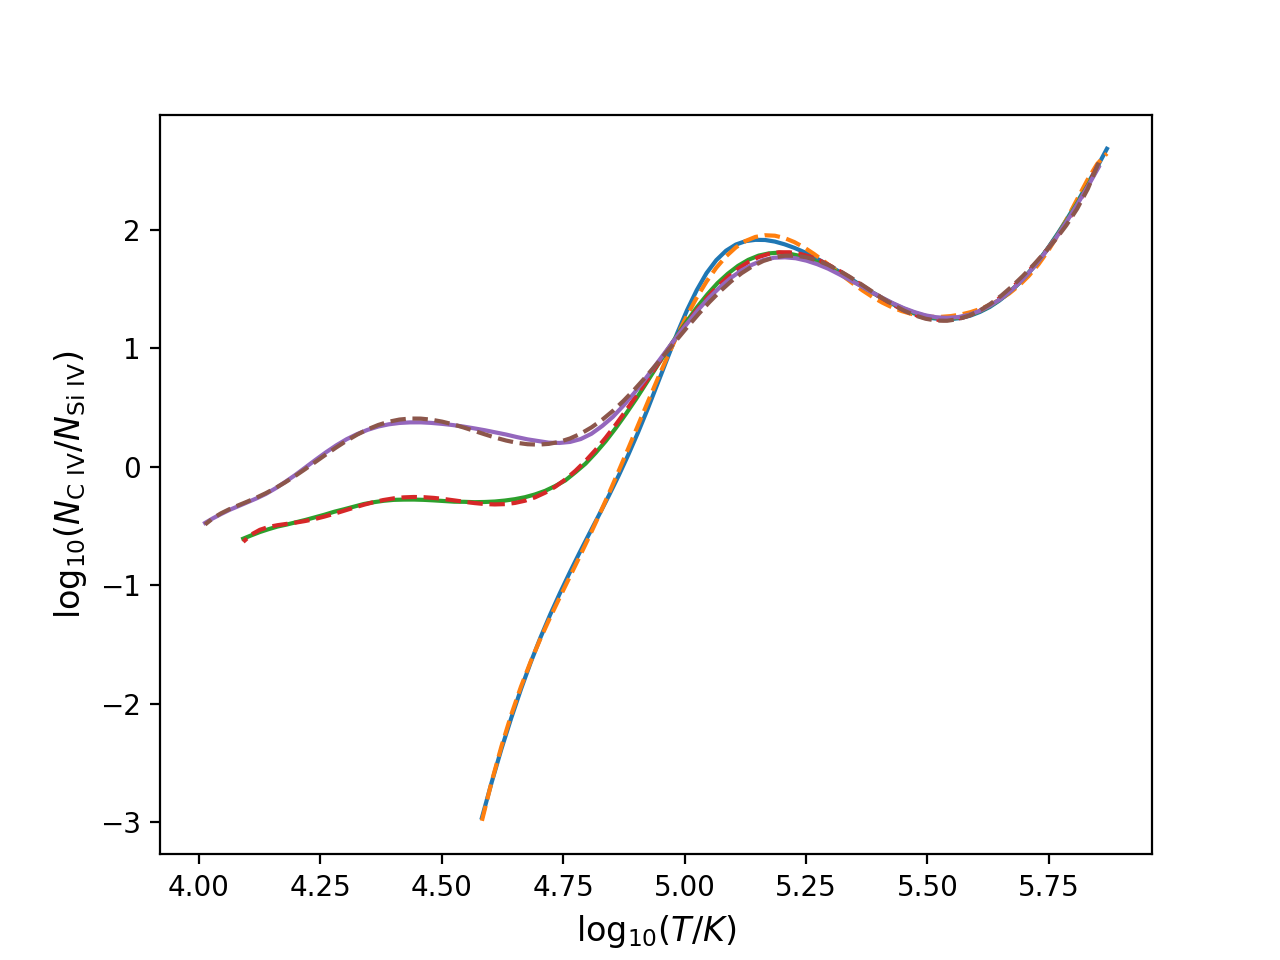

Text(0, 0.5, '$\\log_{10}(N_\\mathrm{C~IV} / N_\\mathrm{Si~IV})$')

In [9]:
fig,ax = plt.subplots()

ax.plot(np.log10(CIE_T), CIV_to_SiIV_CIE)
ax.plot(np.log10(CIE_T)[mask_CIE], np.poly1d(CIE_CIV_SiIV_poly)(np.log10(CIE_T)[mask_CIE]),
        "--")

ax.plot(np.log10(ISOB_Zp1_T), CIV_to_SiIV_ISOB_Zp1)
ax.plot(np.log10(ISOB_Zp1_T)[mask_ISOB], np.poly1d(ISOB_Zp1_CIV_SiIV_poly)(np.log10(ISOB_Zp1_T)[mask_ISOB]),
        "--")

ax.plot(np.log10(ISOCh_Zp1_T), CIV_to_SiIV_ISOCh_Zp1)
ax.plot(np.log10(ISOCh_Zp1_T)[mask_ISOCh], np.poly1d(ISOCh_Zp1_CIV_SiIV_poly)(np.log10(ISOCh_Zp1_T)[mask_ISOCh]),
        "--")

ax.set_xlabel(r"$\log_{10}(T/K)$", fontsize = 12)
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C~IV} / N_\mathrm{Si~IV})$", fontsize = 12)


In [10]:
# Find Roots

def find_temperature_solutions(log_ratio, mtype = "CIE"):
    if mtype == "CIE":
        #CIE
        pp_CIE = np.copy(CIE_CIV_SiIV_poly)
        pp_CIE[-1] -= log_ratio

        r = np.roots(pp_CIE)
        real_valued = r.real[np.abs(r.imag)<1e-5] # where I chose 1-e5 as a threshold

        roots = real_valued[((real_valued < CIE_CIV_SiIV_Trange[1]) & 
                                 (real_valued > CIE_CIV_SiIV_Trange[0]))]
    
    if mtype == "ISOB":
        #ISOB
        pp_ISOB = np.copy(ISOB_Zp1_CIV_SiIV_poly)
        pp_ISOB[-1] -= log_ratio

        r = np.roots(pp_ISOB)
        real_valued = r.real[np.abs(r.imag)<1e-5] # where I chose 1-e5 as a threshold

        roots = real_valued[((real_valued < ISOB_Zp1_CIV_SiIV_Trange[1]) & 
                                 (real_valued > ISOB_Zp1_CIV_SiIV_Trange[0]))]

    if mtype == "ISOCh":
        #ISOCh
        pp_ISOCh = np.copy(ISOCh_Zp1_CIV_SiIV_poly)
        pp_ISOCh[-1] -= log_ratio

        r = np.roots(pp_ISOCh)
        real_valued = r.real[np.abs(r.imag)<1e-5] # where I chose 1-e5 as a threshold

        roots = real_valued[((real_valued < ISOCh_Zp1_CIV_SiIV_Trange[1]) & 
                                 (real_valued > ISOCh_Zp1_CIV_SiIV_Trange[0]))]
    
    
    return roots
    

def boot_temp_solutions(log_ratio, log_ratio_err, Nboot = 1000, mtype = "CIE"):
    arr  =  np.array([find_temperature_solutions(log_ratio + log_ratio_err * np.random.randn(), mtype = mtype) 
                           for ell in range(Nboot)])
    return np.concatenate(arr)





In [11]:
# Global Temperature Analysis
good_ratio_mask = (np.invert(full_ideal_res["LOG_CIV/SiIV"].mask) & (full_ideal_res["ERR_LOG_CIV/SiIV"].data < 0.5))

In [12]:
CIE_T_ests = np.concatenate([np.array(boot_temp_solutions(lr, lre, mtype = "CIE"))
                        for lr,lre in zip(full_ideal_res["LOG_CIV/SiIV"][good_ratio_mask],
                                          full_ideal_res["ERR_LOG_CIV/SiIV"][good_ratio_mask])]).T

ISOB_T_ests = np.concatenate([np.array(boot_temp_solutions(lr, lre, mtype = "ISOB"))
                        for lr,lre in zip(full_ideal_res["LOG_CIV/SiIV"][good_ratio_mask],
                                          full_ideal_res["ERR_LOG_CIV/SiIV"][good_ratio_mask])]).T

ISOCh_T_ests = np.concatenate([np.array(boot_temp_solutions(lr, lre, mtype = "ISOCh"))
                        for lr,lre in zip(full_ideal_res["LOG_CIV/SiIV"][good_ratio_mask],
                                          full_ideal_res["ERR_LOG_CIV/SiIV"][good_ratio_mask])]).T

/var/folders/yk/6d2kh4j15294grmssy2gp_b40000gn/T/ipykernel_64308/1589192996.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr  =  np.array([find_temperature_solutions(log_ratio + log_ratio_err * np.random.randn(), mtype = mtype)


<IPython.core.display.Javascript object>


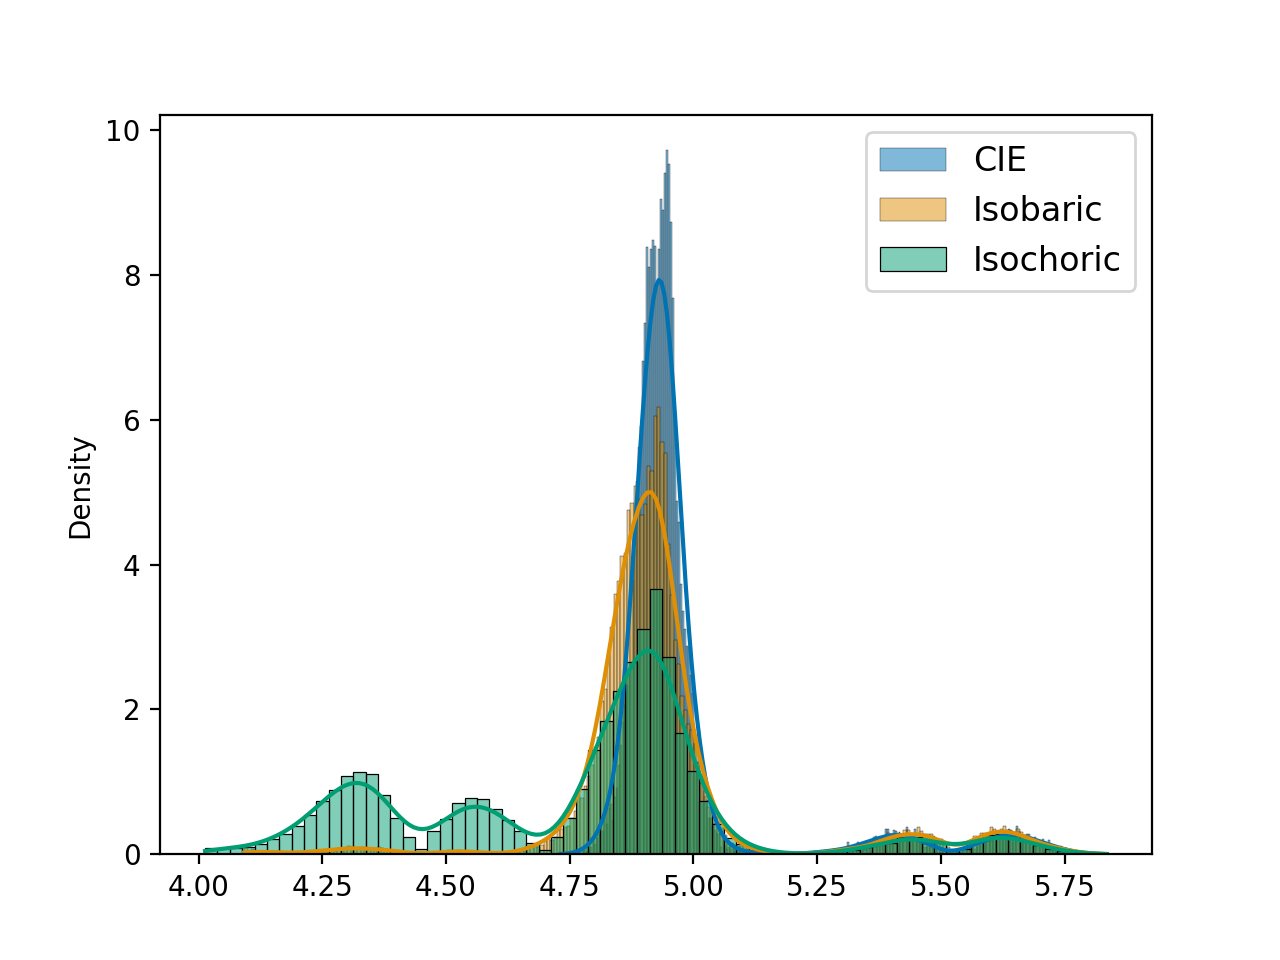

In [13]:
fig,ax = plt.subplots()

sns.histplot(x = CIE_T_ests, ax = ax, color = pal[0], kde = True, 
             stat= "density", label = "CIE")
sns.histplot(x = ISOB_T_ests, ax = ax, color = pal[1], kde = True, 
             stat= "density", label = "Isobaric")
sns.histplot(x = ISOCh_T_ests, ax = ax, color = pal[2], kde = True, 
             stat = "density", label = "Isochoric")

lg = ax.legend(fontsize = 12)

In [20]:
# Save temperature distributions for later
with open("Data/COL_TEMPS.pkl", "wb") as f:
    pickle.dump({"CIE_T":CIE_T_ests, "ISOB_T":ISOB_T_ests, "ISOCh_T":ISOCh_T_ests},f)

# HII Conversions at T = 10^4.9 K

<IPython.core.display.Javascript object>


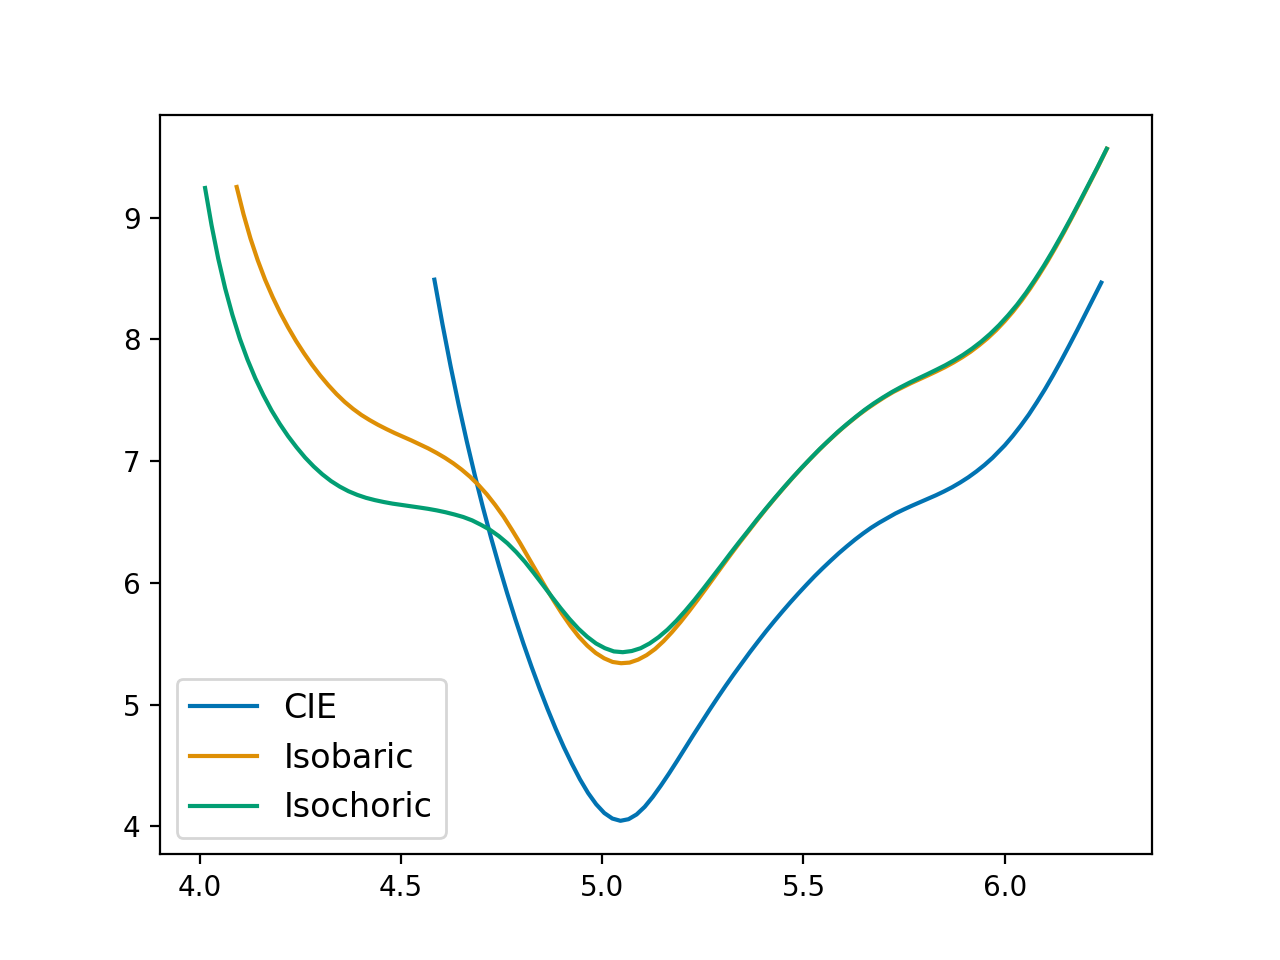

In [14]:
fig,ax = plt.subplots()

ax.plot(np.log10(CIE_T), HII_to_CIV_CIE, label = "CIE", color = pal[0])
ax.plot(np.log10(ISOB_Zp1_T), HII_to_CIV_ISOB_Zp1, label = "Isobaric", color = pal[1])
ax.plot(np.log10(ISOCh_Zp1_T), HII_to_CIV_ISOCh_Zp1, label = "Isochoric", color = pal[2])

lg = ax.legend(fontsize = 12)

In [15]:
CIE_HII_CIV_interper = interp1d(np.log10(CIE_T)[np.invert(np.isnan(HII_to_CIV_CIE) | 
                                                          np.isinf(HII_to_CIV_CIE))], 
                               HII_to_CIV_CIE[np.invert(np.isnan(HII_to_CIV_CIE) | 
                                                        np.isinf(HII_to_CIV_CIE))])

ISOB_HII_CIV_interper = interp1d(np.log10(ISOB_Zp1_T)[np.invert(np.isnan(HII_to_CIV_ISOB_Zp1) | 
                                                                np.isinf(HII_to_CIV_ISOB_Zp1))], 
                               HII_to_CIV_ISOB_Zp1[np.invert(np.isnan(HII_to_CIV_ISOB_Zp1) | 
                                                        np.isinf(HII_to_CIV_ISOB_Zp1))])

ISOCh_HII_CIV_interper = interp1d(np.log10(ISOCh_Zp1_T)[np.invert(np.isnan(HII_to_CIV_ISOCh_Zp1) | 
                                                                np.isinf(HII_to_CIV_ISOCh_Zp1))], 
                               HII_to_CIV_ISOCh_Zp1[np.invert(np.isnan(HII_to_CIV_ISOCh_Zp1) | 
                                                        np.isinf(HII_to_CIV_ISOCh_Zp1))])

In [16]:
CIE_HII_CIV_factor = CIE_HII_CIV_interper(4.9)
ISOB_HII_CIV_factor = ISOB_HII_CIV_interper(4.9)
ISOCh_HII_CIV_factor = ISOCh_HII_CIV_interper(4.9)

ISOCh_HII_CIV_factor_lowT = ISOCh_HII_CIV_interper(4.3)

In [17]:
# Summed columns
summed_columns = QTable.read("Data/SUMMED_ION_COLUMNS.fits")

In [19]:
summed_columns["CIE_LOG_N_HII"] = summed_columns["LOG_N_CIV"] + CIE_HII_CIV_factor
summed_columns["CIE_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_CIV"]

summed_columns["ISOB_LOG_N_HII"] = summed_columns["LOG_N_CIV"] + ISOB_HII_CIV_factor
summed_columns["ISOB_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_CIV"]

summed_columns["ISOCh_LOG_N_HII"] = summed_columns["LOG_N_CIV"] + ISOCh_HII_CIV_factor
summed_columns["ISOCh_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_CIV"]

summed_columns["ISOCh_lowT_LOG_N_HII"] = summed_columns["LOG_N_CIV"] + ISOCh_HII_CIV_factor_lowT
summed_columns["ISOCh_lowT_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_CIV"]

# OVI HII

In [39]:
ISOCh_HII_CIV_factor

array(5.77788603)

In [35]:
summed_columns["CIE_CORONA_LOG_N_HII"] = summed_columns["LOG_N_OVI"] + np.min(HII_to_OVI_CIE)
summed_columns["CIE_CORONA_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_OVI"]

summed_columns["ISOB_CORONA_LOG_N_HII"] = summed_columns["LOG_N_OVI"] + np.min(HII_to_OVI_ISOB_Zp1)
summed_columns["ISOB_CORONA_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_OVI"]

summed_columns["ISOCh_CORONA_LOG_N_HII"] = summed_columns["LOG_N_OVI"] + np.min(HII_to_OVI_ISOCh_Zp1)
summed_columns["ISOCh_CORONA_LOG_N_ERR_HII"] = summed_columns["LOG_N_ERR_OVI"]

In [36]:
summed_columns

SOURCE,RHO_LMC,MEAN_CIV_V,LOG_N_OVI,LOG_N_ERR_OVI,LOG_N_CIV,LOG_N_ERR_CIV,LOG_N_SiIV,LOG_N_ERR_SiIV,LOG_N_CII,LOG_N_ERR_CII,LOG_N_SiII,LOG_N_ERR_SiII,LOG_N_SiIII,LOG_N_ERR_SiIII,LOG_N_AlII,LOG_N_ERR_AlII,LOG_N_FeII,LOG_N_ERR_FeII,LOG_N_OI,LOG_N_ERR_OI,GAL_LON,GAL_LAT,CIE_LOG_N_HII,CIE_LOG_N_ERR_HII,ISOB_LOG_N_HII,ISOB_LOG_N_ERR_HII,ISOCh_LOG_N_HII,ISOCh_LOG_N_ERR_HII,ISOCh_lowT_LOG_N_HII,ISOCh_lowT_LOG_N_ERR_HII,CIE_CORONA_LOG_N_HII,ISOB_CORONA_LOG_N_HII,ISOCh_CORONA_LOG_N_HII,CIE_CORONA_LOG_N_ERR_HII,ISOB_CORONA_LOG_N_ERR_HII,ISOCh_CORONA_LOG_N_ERR_HII
,kpc,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,
bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
PKS0637-75,6.738090605662797,315.21209141225086,--,--,13.847500042416913,0.21486380232322203,13.023835640364153,0.5834980364754688,14.592223957303432,0.20825515522942822,14.423482925766141,0.05965410886436371,13.943778188150093,0.11270708941170897,13.04697716400103,0.10184503532865698,14.34355276410756,0.09105571480132185,15.120269343978967,0.1621508215075317,286.3683639918138,-27.158416955795435,18.53168780844792,0.21486380232322203,19.59409086526601,0.21486380232322203,19.625386068748355,0.21486380232322203,20.752428094566845,0.21486380232322203,--,--,--,--,--,--
HE0246-4101,35.27897737979494,--,--,--,12.981771111610092,-1.0,12.90625051328287,0.09087708138797361,14.454491193099607,0.0314211379546636,13.985330626860792,0.030371764799867952,13.872228473994195,0.5783835389656298,12.697159077902358,0.12130725843288087,13.95290739153146,0.15751291176463264,13.264662529903703,-1.0,250.16044154586777,-62.40148587222074,17.665958877641096,-1.0,18.72836193445919,-1.0,18.75965713794153,-1.0,19.88669916376002,-1.0,--,--,--,--,--,--
RBS144,34.84783718629925,181.12309569155778,13.874134462156777,0.10900524502448398,13.111985886935148,0.13628899426228863,12.19051614380182,-1.0,13.867881652947965,0.03906319793496885,12.728003183988772,0.03615444078856229,12.862999592175289,0.04087709294311042,11.655409049885188,-1.0,13.097197668583595,-1.0,13.748984570547393,-1.0,299.48369588633375,-65.83616648873654,17.796173652966154,0.13628899426228863,18.858576709784245,0.13628899426228863,18.88987191326659,0.13628899426228863,20.01691393908508,0.13628899426228863,17.851696002241177,18.92168337242635,18.958825180430914,0.10900524502448398,0.10900524502448398,0.10900524502448398
PKS0552-640,5.582843113709493,361.99659836006555,14.390315012963955,-1.0,13.874675995667005,0.1846756233686016,12.451331517447395,0.18747038876643973,14.856101080776329,0.13473122594024226,14.232661082789123,0.07775236711870939,13.99398163764152,0.1514998958590301,13.212104181402346,0.1003447437663694,14.038385439196457,0.2253596788523948,14.699398372260832,0.11851215583123938,273.4655755409904,-30.611442195488028,18.55886376169801,0.1846756233686016,19.621266818516105,0.1846756233686016,19.652562021998445,0.1846756233686016,20.779604047816935,0.1846756233686016,18.367876553048355,19.43786392323353,19.47500573123809,-1.0,-1.0,-1.0
PKS0202-76,13.82286390875724,275.8650137714024,--,--,13.445831605889019,0.21566071528656142,12.818391107782787,0.22672379738340956,14.814676037521908,0.6817968089522809,14.598577647820482,0.05350045542988317,14.174878848266244,0.2341701268572903,13.331226184956481,0.1235015766150336,14.424421417080833,0.1984660328967396,15.240034082557358,0.13499753644187712,297.54865746073773,-40.04515968380045,18.130019371920024,0.21566071528656142,19.19242242873812,0.21566071528656142,19.22371763222046,0.21566071528656142,20.35075965803895,0.21566071528656142,--,--,--,--,--,--
HE0003-5023,42.69080167301347,--,--,--,12.538038259787562,-1.0,12.073105125154955,-1.0,12.672290827079202,-1.0,11.257679148935926,-1.0,11.60977936887398,-1.0,11.678059820471963,-1.0,12.947329831446304,-1.0,--

In [37]:
summed_columns.write("Data/SUMMED_ION_COLUMNS_wHII.fits")